## Setup

This section contains supplementary information and installs required packages.

In [0]:
!pip install tensorflow-gpu==2.0 tensorflow_datasets gpustat -Uq

**About**

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/6/6d/Nvidia_image_logo.svg/200px-Nvidia_image_logo.svg.png" width="90px" align="right" style="margin-right: 0px;">

This notebook is put together by Timothy Liu (`timothyl@nvidia.com`) for the [**PyCon SG**](https://pycon.sg/) 2019 tutorial on [**Improving Deep Learning Performance in TensorFlow**](https://github.com/NVAITC/pycon-sg19-tensorflow-tutorial).

**Acknowledgements**

* This notebook uses some materials adapted from TensorFlow documentation.

**Dataset Citation**

```
@InProceedings{Nilsback08,
   author = "Nilsback, M-E. and Zisserman, A.",
   title = "Automated Flower Classification over a Large Number of Classes",
   booktitle = "Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing",
   year = "2008",
   month = "Dec"
}
```

# TensorFlow Datasets

[**TensorFlow Datasets**](https://www.tensorflow.org/datasets) is a TensorFlow library that makes a collection of datasets easily usable within TensorFlow as `tf.data.Datasets`.

This enables users to quickly create high-performance input pipelines for various datasets and use them for training models.

In [2]:
import tensorflow
print("TensorFlow version:", tensorflow.__version__)

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

TensorFlow version: 2.0.0


In [0]:
# to list all datasets:
#tfds.list_builders()
# also see: https://www.tensorflow.org/datasets/catalog/overview#all_datasets

## Loading Dataset

In this demo, we are going to be loading the [**Oxford Flowers 102**](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset, which is a relatively small dataset of 102 classes of flowers. 

Using [TensorFlow Datasets](https://www.tensorflow.org/datasets) and `tf.data`, we can easily download and load the dataset without having to write boilerplate loading code.

In [0]:
oxford_102, info = tfds.load(
    name="oxford_flowers102",  # selects which dataset to load
    shuffle_files=True,        # automatically shuffle files
    with_info=True             # extra metadata about the dataset
)

If there is a standardised split, it will already be pre-configured in the loaded dataset.

In [0]:
train_dataset = oxford_102["train"]
try:
    valid_dataset = oxford_102["validation"]
    test_dataset  = oxford_102["test"]
except Exception as e:
    print("Some datasets don't have a pre-defined validation/test set!")
    print(e)

Each of the splits are is an instance of a `tf.data` `Dataset` object, although the exact type might differ depending on the last operation being run in the pipeline.

In [6]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

Loading the dataset with the `with_info=True` argument allows us to get curated information (`info`) for the dataset. 

In [7]:
print("Dataset Name:")
print(info.name)
print("\nDataset Description:")
print(info.description)
print("Dataset Split:")
info.splits

Dataset Name:
oxford_flowers102

Dataset Description:

The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1030 images each).
The test set consist of the remaining 6129 images (minimum 20 per class).

Dataset Split:


{'test': <tfds.core.SplitInfo num_examples=6149>,
 'train': <tfds.core.SplitInfo num_examples=1020>,
 'validation': <tfds.core.SplitInfo num_examples=1020>}

## Taking Individual Examples

Examples can be manually retrieved from a `Dataset` using the `take()` method, which will then return a list of examples. Each example is pre-formatted in a way defined by the `Dataset` object.

Example: 0
Keys: dict_keys(['file_name', 'image', 'label'])


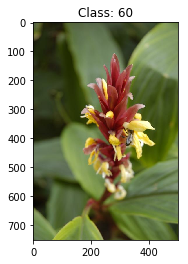

In [8]:
from matplotlib import pyplot as plt

# try changing the number of examples to take!

examples = train_dataset.take(1)

# iterate through the list of examples

for i, example in enumerate(examples):
    print("Example:", i)
    print("Keys:", example.keys())
    title_string = "Class: " + str(example["label"].numpy())
    plt.title(title_string)
    plt.imshow(example["image"])
    plt.show()

## Building a pipeline

When using TensorFlow Datasets, it might be easier to load a training set as seen below.

Note the arguments `split` and `as_supervised=True`.

You can also change the image dataset being used by modifying the `name` argument. Check out other possible datasets [here](https://www.tensorflow.org/datasets/catalog/overview). Make sure to use an image dataset!

In [0]:
# Let's reload the dataset in a slightly different way

train_dataset = tfds.load(
    name="oxford_flowers102", # selects which dataset to load
    split=tfds.Split.TRAIN,   # load training dataset directly
    shuffle_files=True,       # automatically shuffle files
    as_supervised=True        # return data as (image, label) tuple
)

**Formatting Input Examples**

We need to resize and normalise our image with a function.

To improve performance, we set a `@tf.function` decorator on the function to compile it using TF AutoGraph. ([read more](https://www.tensorflow.org/tutorials/customization/performance))

This works well with TensorFlow functions and Python control flow (`if`-`else`, loops etc.).

In [0]:
IMG_SIZE = (224, 224)

@tf.function
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    image = (image/255)
    return image, label

**Composing the Pipeline**

In `tf.data`, input pipelines are built by chaining functions on a `Dataset` object.

Now, we will build an input pipeline for training an image classifier for this task:

1. Shuffle the dataset, per block of 1024 images
2. Format each training example (e.g. resize the image) using multiple threads
3. Form batches of examples (9 used for demonstration purposes)
4. Prefetch (pre-load into RAM) 1 **batch** for performance reasons

**Note: Autotuning the Pipeline**

For certain values above (e.g. prefetch count or map thread count), you can use `tf.data.experimental.AUTOTUNE` to let TensorFlow automatically calibrate the optimal number using Bayesian optimisation. This may not always result in the best performance, but is a good starting point if you are unsure of what number to choose. Otherwise, you should set sensible values (e.g. set number of threads to the number of logical cores on the system).

In [0]:
import multiprocessing

BATCH_SIZE = 9
N_THREADS = multiprocessing.cpu_count()

train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.map(format_example, num_parallel_calls=N_THREADS)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(1)

**Running the Pipeline**

Note that running the above cell only builds up the dataflow graph of the input pipeline, but doesn't actually run it!

Hence, the first time you take examples from the dataset might be slow due to the initialisation.

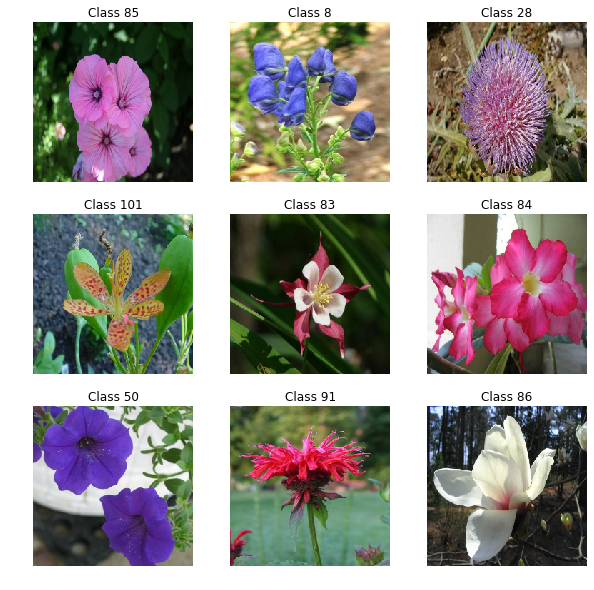

In [12]:
plt.figure(figsize=(10,10))

# try changing the number of batches to take below

batches = train_dataset.take(1)

# iterate through the list of batches

for batch in batches:
    image_batch = batch[0]
    labels_batch = batch[1]
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.title("Class {}".format(labels_batch[i]))
        plt.imshow(image_batch[i])
        plt.axis("off")
    plt.show()